In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models

In [ ]:
import zipfile
zip_path = '/content/augmented_dataset.zip'

extract_folder = '/content/'

os.makedirs(extract_folder, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"File ZIP telah diekstrak ke: {extract_folder}")


File ZIP telah diekstrak ke: /content/


In [ ]:
dataset_dir = './augmented_dataset/'
output_dir = './split_dataset/'

train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))]
        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))



In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
class_names = os.listdir(train_dir)
num_classes = len(class_names)

training_dataset = tf.keras.utils.image_dataset_from_directory(
        directory='./split_dataset/train',
        batch_size=32,
        image_size=(150, 150),
        shuffle=True,
        seed=7
    )

validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory='./split_dataset/validation',
        batch_size=32,
        image_size=(150, 150),
        shuffle=True,
        seed=7
    )

Found 8469 files belonging to 5 classes.
Found 2118 files belonging to 5 classes.


In [ ]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (150, 150))
    image = image / 255.0
    return image, label

training_dataset = training_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

training_dataset = training_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
for batch in validation_dataset.take(1):
    images, labels = batch
    print(images.shape, labels.shape)

(32, 150, 150, 3) (32,)


In [ ]:
val_batches = int(validation_dataset.cardinality())
split_index = val_batches // 5

test_dataset = validation_dataset.take(split_index)
validation_dataset = validation_dataset.skip(split_index)

print(f'Number of validation batches: {validation_dataset.cardinality()}')
print(f'Number of test batches: {test_dataset.cardinality()}')

Number of validation batches: 54
Number of test batches: 13


In [ ]:
pre_trained_model = tf.keras.applications.MobileNet(
        include_top=False,
        input_shape=(150, 150, 3),
        weights='imagenet'
    )
pre_trained_model.trainable = False

<ipython-input-13-b3b5e872a232>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained_model = tf.keras.applications.MobileNet(


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
num_total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {num_total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")
pre_trained_model.summary()

There are 3,228,864 total parameters in this model.
There are 0 trainable parameters in this model.


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 75, 75, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 75, 75, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 75, 75, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 75, 75, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 75, 75, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 75, 75, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 76, 76, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 37, 37, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 37, 37, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 37, 37, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 37, 37, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 37, 37, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 37, 37, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 37, 37, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy']>0.999:
            self.model.stop_training = True
            print("\nReached 99.9% accuracy so cancelling training!")

In [ ]:
last_desired_layer = pre_trained_model.get_layer('conv_pw_13_relu')
last_output = last_desired_layer.output

print('last layer output shape: ', last_output.shape)

last layer output shape:  (None, 4, 4, 1024)


In [ ]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
training_dataset = training_dataset.map(lambda image, label: (tf.keras.applications.mobilenet.preprocess_input(image), label))
validation_dataset = validation_dataset.map(lambda image, label: (tf.keras.applications.mobilenet.preprocess_input(image), label))
test_dataset = test_dataset.map(lambda image, label: (tf.keras.applications.mobilenet.preprocess_input(image), label))


In [ ]:
history = model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 100,
    verbose = 2,
    callbacks = [EarlyStoppingCallback()],
)

Epoch 1/100
265/265 - 22s - 83ms/step - accuracy: 0.3936 - loss: 1.4334 - val_accuracy: 0.5699 - val_loss: 1.2616
Epoch 2/100
265/265 - 9s - 33ms/step - accuracy: 0.5308 - loss: 1.2186 - val_accuracy: 0.5411 - val_loss: 1.1529
Epoch 3/100
265/265 - 10s - 36ms/step - accuracy: 0.5676 - loss: 1.1212 - val_accuracy: 0.6322 - val_loss: 1.0444
Epoch 4/100
265/265 - 10s - 37ms/step - accuracy: 0.6027 - loss: 1.0523 - val_accuracy: 0.6222 - val_loss: 0.9853
Epoch 5/100
265/265 - 9s - 32ms/step - accuracy: 0.6232 - loss: 1.0006 - val_accuracy: 0.5864 - val_loss: 1.0001
Epoch 6/100
265/265 - 7s - 27ms/step - accuracy: 0.6260 - loss: 0.9772 - val_accuracy: 0.6281 - val_loss: 0.9415
Epoch 7/100
265/265 - 9s - 32ms/step - accuracy: 0.6495 - loss: 0.9289 - val_accuracy: 0.6287 - val_loss: 0.9113
Epoch 8/100
265/265 - 10s - 37ms/step - accuracy: 0.6559 - loss: 0.9089 - val_accuracy: 0.6727 - val_loss: 0.8591
Epoch 9/100
265/265 - 7s - 27ms/step - accuracy: 0.6603 - loss: 0.8920 - val_accuracy: 0.675

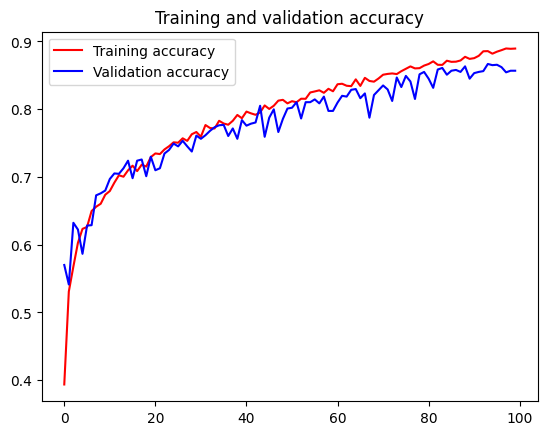

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test loss: {test_loss},\nTest accuracy: {test_accuracy}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8631 - loss: 0.3597
Test loss: 0.3202260434627533,
Test accuracy: 0.879807710647583


In [ ]:
model.save('FishGuard.h5')
from google.colab import files

files.download('FishGuard.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r split_dataset.zip split_dataset
from google.colab import files
files.download("split_dataset.zip")